## smoothing preproc images using nipype

In [1]:
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold, IsotropicSmooth)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

200930-19:29:28,155 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


### check TR

In [2]:
import numpy as np
import nibabel as nib

In [3]:
func_img = nib.load('/data/sub-06/func/sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

In [4]:
header = func_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 2.0)

image spatial voxel sizes (2.4 x 2.4 x 3.12)mm, TR=2s

In [5]:
print(header.get_data_shape())

(81, 96, 63, 246)


shape of image array 246 vols

### nipype smoothing workflow

In [5]:
experiment_dir = '/output'
output_dir = 'smooth'
working_dir = 'workingdir'
data_dir = '/data'

# TR of functional images
TR = 2.

In [6]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# Smooth - image smoothing
smooth = Node(Smooth(fwhm=[8,8,8]), name="smooth")
# smooth = Node(IsotropicSmooth(fwhm=4), name='smooth')

### specify input/output

In [7]:
sj_ls = []
for f in os.listdir('/data/'):
    if f.endswith('.html'):
#         print(f)
        sj_ls.append(f[4:6])
print(sj_ls)
print(len(sj_ls))

['36', '43', '09', '16', '19', '33', '08', '32', '21', '42', '31', '17', '07', '14', '23', '13', '15', '44', '18', '37', '28', '29', '24', '26', '41', '20', '06', '27', '30', '38', '11', '25', '10', '22', '39']
35


In [8]:
# crashed within subject 29, remaining runs other than 3-4
sj_ls.remove('29')

In [9]:
print(len(sj_ls))

34


In [ ]:
# sort subjects according to 
for sj in sj_ls:
    fl = []
    for f in os.listdir('/data/sub-'+sj+'/func'):
        if f.endswith('bold.nii.gz'):
#             print(f)
            fl.append(f[20])
    print(f'subject %s has %s sessions.' % (sj, fl))
    # run
    preproc = define_workflow([sj], fl, experiment_dir, output_dir)
    preproc.run('MultiProc', plugin_args={'n_procs': 4})

In [10]:
def define_workflow(subject_list, run_list, experiment_dir, output_dir):
    """run the smooth workflow given subject and runs"""
    # ExtractROI - skip dummy scans
    extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

    # Smooth - image smoothing
    smooth = Node(Smooth(fwhm=[8,8,8]), name="smooth")
    
    # Infosource - a function free node to iterate over the list of subject names
    # subject_list = ['39']
    # run_list = ['1','2','3','4','5']

    # infosource = Node(IdentityInterface(fields=['subject_id']),
    infosource = Node(IdentityInterface(fields=['subject_id','run_num']),
                      name="infosource")
    infosource.iterables = [('subject_id', subject_list),
                           ('run_num', run_list)]

    # SelectFiles - to grab the data (alternativ to DataGrabber)
    func_file = opj('sub-{subject_id}', 'func',
                    'sub-{subject_id}_task-tsl_run-{run_num}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

    templates = {'func': func_file}
    selectfiles = Node(SelectFiles(templates,
                        base_directory=data_dir),
                       name="selectfiles")

    # Datasink - creates output folder for important outputs
    datasink = Node(DataSink(base_directory=experiment_dir,
                             container=output_dir),
                    name="datasink")

    ## Use the following DataSink output substitutions
    substitutions = [('_subject_id_', 'sub-'),
                     ('ssub', 'sub'),
                     ('_space-MNI152NLin2009cAsym_desc-preproc_', '_fwhm-8_'),
                     ('_fwhm_', ''),
                     ('_roi', '')
                     ]
    substitutions += [('_run_num_%s' % r, '') for r in run_list]
    # substitutions += [('_subject_id_%s/detrend' % s,
    #                    '_subject_id_%s/sub-%s_detrend' % (s, s)) for s in subject_list]
    # subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
    # substitutions.extend(subjFolders)
    datasink.inputs.substitutions = substitutions
    
    # Create a preprocessing workflow
    preproc = Workflow(name='preproc')
    preproc.base_dir = opj(experiment_dir, working_dir)
    
    # Connect all components of the preprocessing workflow (spm smooth)
    preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                           ('run_num', 'run_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, smooth, [('roi_file', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')])
                ])
    return preproc

### previous code

In [78]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

In [79]:
# Connect all components of the preprocessing workflow (spm smooth)
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
#                                            ('run_num', 'run_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, smooth, [('roi_file', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')])
                ])

In [42]:
# # Connect all components of the preprocessing workflow (fsl smooth)
# preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
#                                            ('run_num', 'run_num')]),
#                  (selectfiles, extract, [('func', 'in_file')]),
#                  (extract, smooth, [('roi_file', 'in_file')]),
#                  (smooth, datasink, [('out_file', 'preproc.@smooth')])
#                 ])

In [23]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

200930-09:54:41,649 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


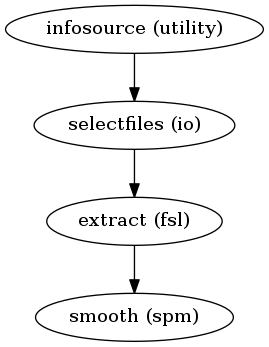

In [44]:
# preproc.write_graph(graph2use='colored', format='png', simple_form=True)
preproc.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

### checking different smooth methods

fslmath

In [10]:
smooth_img = nib.load('/output/smooth/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold_smooth.nii.gz')

In [11]:
header = smooth_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 2.0)

In [12]:
print(header.get_data_shape())

(81, 96, 63, 242)


spm 

In [13]:
smooth_img = nib.load('/output/smooth/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold.nii')

In [14]:
header = smooth_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 0.0)

In [15]:
print(header.get_data_shape())

(81, 96, 63, 242)


In [18]:
from nilearn.plotting import plot_anat, plot_epi, plot_img
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

# Let's create a short helper function to plot 3D NIfTI images
def plot_slice(fname):

    # Load the image
    img = nb.load(fname)
    data = img.get_data()

    # Cut in the middle of the brain
    cut = int(data.shape[-2]/2) + 10

    # Plot the data
    plt.imshow(np.rot90(data[..., cut, 0]), cmap="gray")
    plt.gca().set_axis_off()

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # This is added back by InteractiveShellApp.init_path()


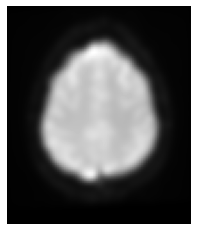

In [20]:
plot_slice('/output/smooth/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold.nii')